In [3]:
import pandas as pd

races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
pitstops = pd.read_csv("pit_stops.csv")
laptimes = pd.read_csv("lap_times.csv")

print("Races:", races.shape)
print("Results:", results.shape)
print("Pitstops:", pitstops.shape)
print("Laptimes:", laptimes.shape)

print(results['positionOrder'].describe())


Races: (1125, 18)
Results: (26759, 18)
Pitstops: (11371, 7)
Laptimes: (589081, 6)
count    26759.000000
mean        12.794051
std          7.665951
min          1.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         39.000000
Name: positionOrder, dtype: float64


In [6]:
from pathlib import Path
import pandas as pd

# 1) Point to your files
# If you already copied with kagglehub → project folder:
DATA_DIR = Path("data/f1_kaggle")     # change if needed

# (If you want to read directly from kagglehub cache, set DATA_DIR = Path(path))

# 2) Load only what we need
laps     = pd.read_csv("lap_times.csv")      # has the target (milliseconds)
races    = pd.read_csv("races.csv")          # to add year/circuit context
results  = pd.read_csv("results.csv")        # to add grid/position context

# 3) Target = lap time (milliseconds)
laps = laps.rename(columns={"milliseconds":"lap_ms"})
laps = laps.dropna(subset=["lap_ms"])

# Optional: keep plausible lap times (40s–180s). Remove if you prefer raw.
laps = laps[(laps.lap_ms >= 40_000) & (laps.lap_ms <= 180_000)]

# 4) Join minimal inputs (features) you likely want available
df = (laps
      .merge(races[["raceId","year","circuitId"]], on="raceId", how="left")
      .merge(results[["raceId","driverId","grid","positionOrder"]],
             on=["raceId","driverId"], how="left"))

# Clean up names
df = df.rename(columns={"positionOrder":"position"})

# 5) Define inputs (X) and output (y)
# Note: circuitId is categorical; you’ll encode it later for modeling.
feature_cols = ["lap", "position", "grid", "year", "circuitId"]
X = df[feature_cols].copy()
y = df["lap_ms"].astype(int)

# 6) Basic checks
print("X shape:", X.shape, "| y shape:", y.shape)
print("Columns (X):", list(X.columns))
print("Sample rows:")
display(df[feature_cols + ["lap_ms"]].head())

# 7) (Optional) Save ready-to-use files
# X.to_parquet("X.parquet"); y.to_frame("lap_ms").to_parquet("y.parquet")
# Or CSV (larger): X.to_csv("X.csv", index=False); y.to_frame("lap_ms").to_csv("y.csv", index=False)


X shape: (587078, 6) | y shape: (587078,)
Columns (X): ['lap', 'position', 'position', 'grid', 'year', 'circuitId']
Sample rows:


,lap,position,position,grid,year,circuitId,lap_ms
0,1,1,1,1,2011,1,98109
1,2,1,1,1,2011,1,93006
2,3,1,1,1,2011,1,92713
3,4,1,1,1,2011,1,92803
4,5,1,1,1,2011,1,92342


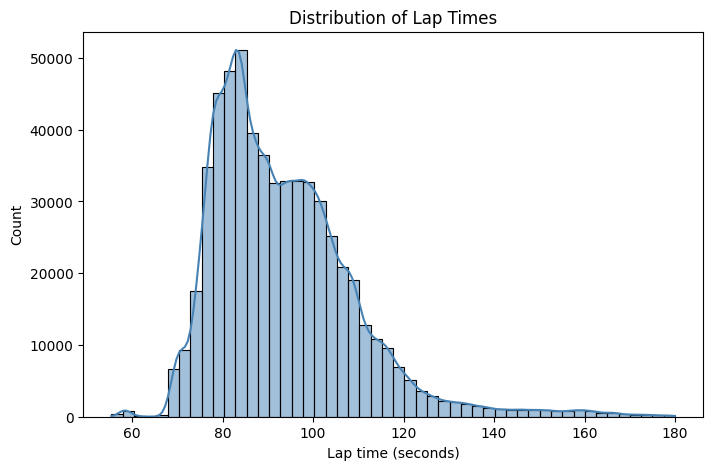

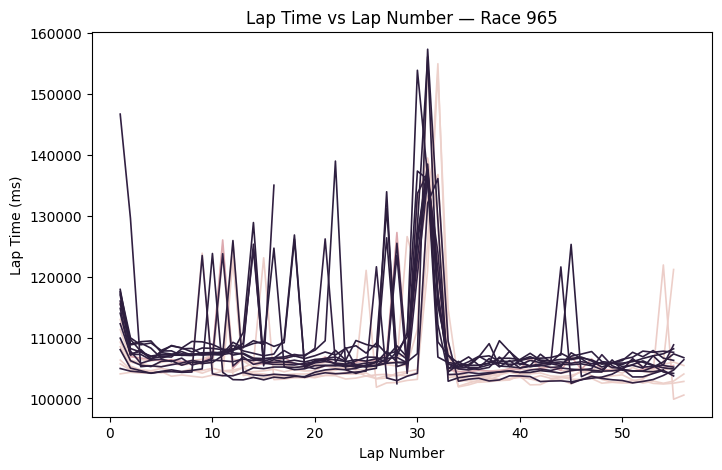

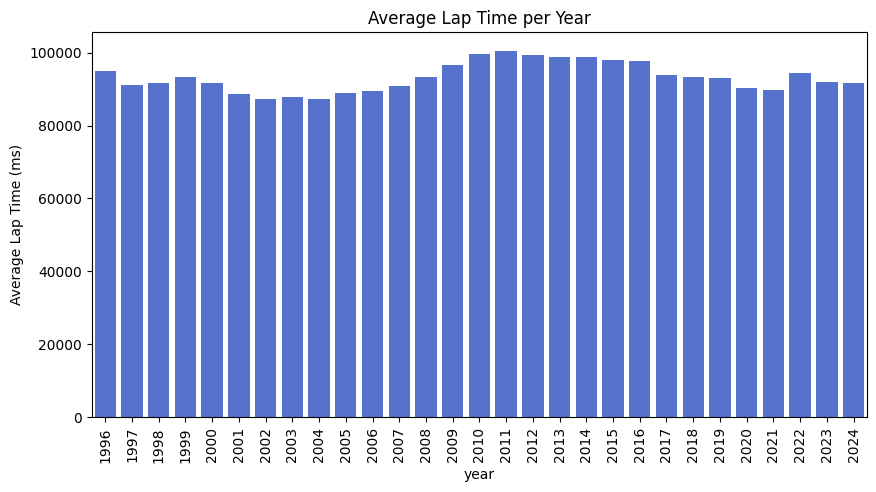

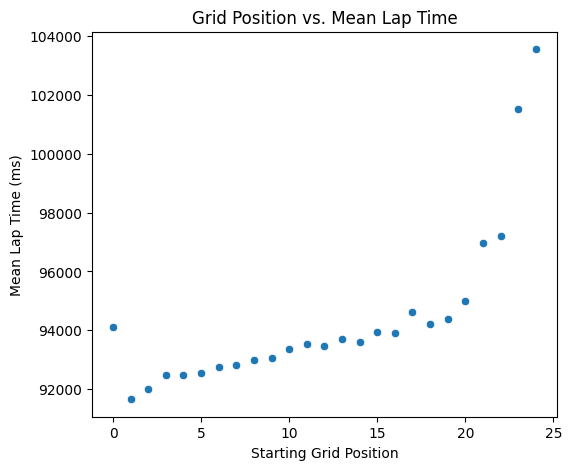

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Distribution of target lap times
plt.figure(figsize=(8,5))
sns.histplot(df["lap_ms"]/1000, bins=50, kde=True, color="steelblue")
plt.xlabel("Lap time (seconds)")
plt.title("Distribution of Lap Times")
plt.show()

# 2) Relationship between lap number and lap time (one random race)
race_sample = df["raceId"].sample(1).iloc[0]
subset = df[df["raceId"] == race_sample]

plt.figure(figsize=(8,5))
sns.lineplot(data=subset, x="lap", y="lap_ms", hue="driverId", linewidth=1.2)
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")
plt.title(f"Lap Time vs Lap Number — Race {race_sample}")
plt.legend([],[], frameon=False)
plt.show()

# 3) Average lap time per year (trend over decades)
plt.figure(figsize=(10,5))
sns.barplot(data=df.groupby("year", as_index=False)["lap_ms"].mean(),
            x="year", y="lap_ms", color="royalblue")
plt.xticks(rotation=90)
plt.ylabel("Average Lap Time (ms)")
plt.title("Average Lap Time per Year")
plt.show()

# 4) Scatter: Grid position vs. average lap time (performance trend)
grid_perf = df.groupby("grid", as_index=False)["lap_ms"].mean()
plt.figure(figsize=(6,5))
sns.scatterplot(data=grid_perf, x="grid", y="lap_ms")
plt.xlabel("Starting Grid Position")
plt.ylabel("Mean Lap Time (ms)")
plt.title("Grid Position vs. Mean Lap Time")
plt.show()
